# Importing Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import glob, cv2
from glob import glob
from random import shuffle
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Directories for our data
train_data_dir = "training_set"
test_data_dir = "testing_set"

# Building our cats dataset class

In [3]:
class MyCats(Dataset):
    def __init__(self, folder):
        salem = glob(folder+"/salem/*.JPG")
        ellie = glob(folder+"/ellie/*.JPG")
        ash = glob(folder+"/ash/*.jpeg")
        cleo = glob(folder+"/cleo/*.jpeg")
        
        self.fpaths = salem + ellie + ash + cleo
        shuffle(self.fpaths)
        
        # Assigning classes to our cats / salem = 0 , ellie = 1, ash = 2, cleo = 3
        self.targets = []
        
        for fpath in self.fpaths:
            fpath = fpath.split("/")[1]
            if fpath == "salem":
                self.targets.append(0)
            elif fpath == "ellie":
                self.targets.append(1)
            elif fpath == "ash":
                self.targets.append(2)
            elif fpath == "cleo":
                self.targets.append(3)
        
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, ix):
        path = self.fpaths[ix]
        target = self.targets[ix]
        img = (cv2.imread(path)[:,:,::-1])
        img = cv2.resize(img, (224, 224))
        
        return torch.tensor(img/255).permute(2, 0, 1).to(device).float(), \
                                    torch.tensor([target]).float().to(device)

## Inspecting a random image

In [4]:
data = MyCats(train_data_dir)
img, label = data[0]

In [5]:
print(img.shape)
print(label)

torch.Size([3, 224, 224])
tensor([2.])


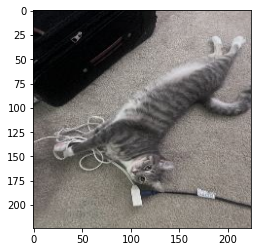

In [6]:
plt.imshow(img.permute(1, 2, 0).cpu())

# Creating our model

## Creating our  convolution layer function

In [7]:
def conv_layer(inpt, outpt, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(inpt, outpt, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(outpt),
        nn.MaxPool2d(2)
    )

## Get model function

In [8]:
def get_model():
    model = nn.Sequential(
                conv_layer(3, 64, 3),
                conv_layer(64, 512, 3),
                conv_layer(512, 512, 3),
                conv_layer(512, 512, 3),
                conv_layer(512, 512, 3),
                conv_layer(512, 512, 3),
                nn.Flatten(),
                nn.Linear(512, 4)
                ).to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return model, loss_fn, optimizer

## Model Summary

In [9]:
model, loss_fn, optim = get_model()
summary(model, torch.zeros(1, 3, 224, 224));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

# Training functions

## Get data function

In [10]:
def get_data():
    train = MyCats(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    
    val = MyCats(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    
    return trn_dl, val_dl

## Training batch function

In [45]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y.squeeze(1).type(torch.LongTensor))
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

## Accuracy function

In [12]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    
    return is_correct.cpu().numpy().tolist()

## Validation loss function

In [13]:
@torch.no_grad()
def val_loss(x, y, model):
    predicition = model(x)
    val_loss = loss_fn(predicition, y)
    
    return val_loss.item()

# Training our model

In [28]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

- Test training loop for errors

In [46]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"Currently working on {epoch} epoch")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        
        train_epoch_losses.append(batch_loss)
        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

Currently working on 0 epoch


KeyboardInterrupt: 